In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.segmentation import fcn_resnet50

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    # def __call__(self, pic):
    #     tensor = super().__call__(pic)
    #     tensor = (tensor * 255).to(torch.int64)
    #     return tensor
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor.squeeze(0)  # Remove the channel dimension


def get_voc_dataloader(batch_size=4):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # TODO: 2 points. Define image transforms for both the input image AND the "label" image.
    # Remember, the labels are one category (integer) per pixel. So, while the image_transform
    # normalize the values to have mean zero and unit standard deviation, you shouldn't 
    # do that with the labels, which have to be integers. I provided a "ToIntTensor" transform
    # above to use for the label transform, instead of ToTensor which always turns images to floats. 
    # Also, we want to resize/crop images to be all the same size, a power of 2, and 
    # we should transform the label and image in the same way when changing size.
    # The size of images will drastically impact memory usage - I suggest targeting 128 x 128 
    # or even 64 x 64 if memory constraints are an issue. 
    # Image transforms
    image_transforms = transforms.Compose([
        transforms.Resize((128, 128)), # Resizing to smaller size for computational efficiency
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ])

    # Label transforms
    label_transforms = transforms.Compose([
        transforms.Resize((128, 128), Image.NEAREST),  # Resizing to smaller size for computational efficiency. Use NEAREST interpolation to avoid creating new class labels.
        ToIntTensor()  # Convert to tensor and to integer
    ])

    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    data_dir = "~/Data/"  # TODO: Specify path to save data
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl
    
    

In [3]:
def train_epoch(model, train_dl, val_dl, optimizer, device):
    """
    Train one epoch of model with optimizer, using data from train_dl.
    Do training on "device". 
    Return the train and validation loss and validation accuracy.
    """
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    # Switch model to training mode
    model.train()

    # Training loop
    train_loss = 0.0
    for images, labels in train_dl:
        # Transfer images and labels to the appropriate device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * images.size(0)

    # Calculate average training loss over an epoch
    train_loss = train_loss / len(train_dl.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for images, labels in val_dl:
            # Transfer to device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)['out']
            loss = criterion(outputs, labels)

            # Update validation loss
            val_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_pixels += (predicted == labels).sum().item()
            total_pixels += labels.nelement()

        # Calculate average validation loss over an epoch
        val_loss = val_loss / len(val_dl.dataset)

        # Calculate accuracy
        accuracy = correct_pixels / total_pixels

    return train_loss, val_loss, accuracy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
batch_size = 64  # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 50
learning_rate = 0.01
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model = fcn_resnet50(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)

# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.)

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model, train_dl, val_dl, optimizer, device)
    
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy))

Using downloaded and verified file: /root/Data/VOCtrainval_06-Nov-2007.tar
Extracting /root/Data/VOCtrainval_06-Nov-2007.tar to /root/Data/
Using downloaded and verified file: /root/Data/VOCtrainval_06-Nov-2007.tar
Extracting /root/Data/VOCtrainval_06-Nov-2007.tar to /root/Data/
Epoch 1: Train loss: 2.411 | Val loss: 2.457 | Acc: 0.398
Epoch 2: Train loss: 0.953 | Val loss: 1.238 | Acc: 0.703
Epoch 3: Train loss: 0.825 | Val loss: 1.514 | Acc: 0.599
Epoch 4: Train loss: 0.638 | Val loss: 1.002 | Acc: 0.724
Epoch 5: Train loss: 0.516 | Val loss: 0.735 | Acc: 0.758
Epoch 6: Train loss: 0.439 | Val loss: 0.825 | Acc: 0.744
Epoch 7: Train loss: 0.388 | Val loss: 0.761 | Acc: 0.763
Epoch 8: Train loss: 0.350 | Val loss: 0.712 | Acc: 0.772
Epoch 9: Train loss: 0.321 | Val loss: 0.816 | Acc: 0.761
Epoch 10: Train loss: 0.287 | Val loss: 0.833 | Acc: 0.760
Epoch 11: Train loss: 0.270 | Val loss: 0.784 | Acc: 0.767
Epoch 12: Train loss: 0.253 | Val loss: 0.752 | Acc: 0.772
Epoch 13: Train loss:

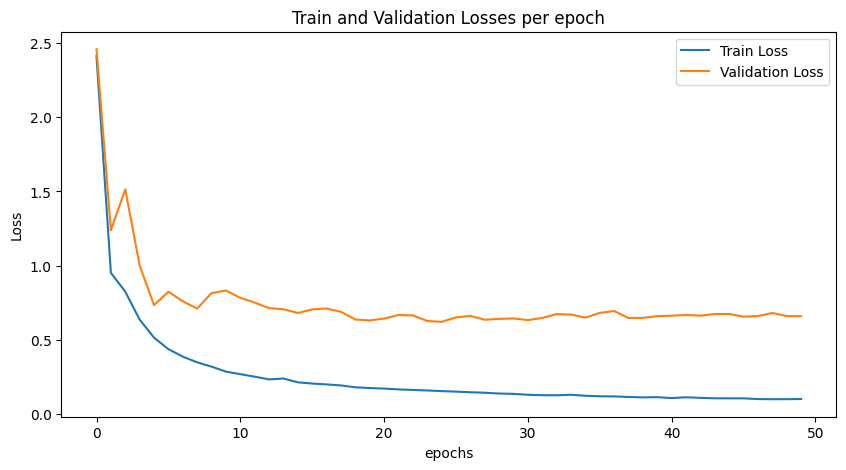

<ipython-input-9-abb4578689a3>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors


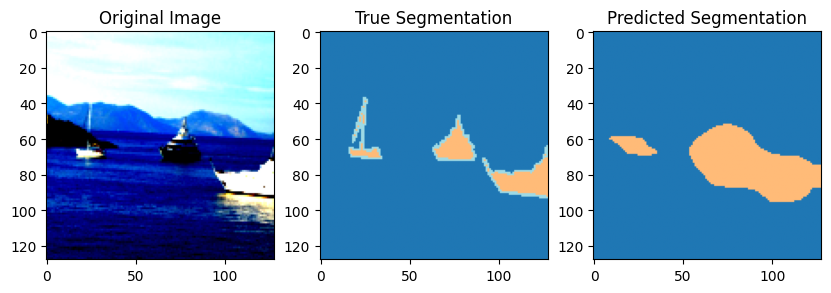

In [9]:
# TODO: Train and test loss plot
plt.figure(figsize=(10,5))
plt.title("Train and Validation Losses per epoch")
plt.plot(train_losses,label="Train Loss")
plt.plot(val_losses,label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# TODO: Print out an example image, true segmentation, and predicted segmentation
def visualize_segmentation(model, dataloader, device, n_class):
    cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)['out']
        _, predicted_label = torch.max(outputs.data, 1)

        # Visualize original image
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.title("Original Image")
        plt.imshow(np.transpose(images[5].cpu().numpy(), (1,2,0)))

        # Visualize True Segmentation
        plt.subplot(1,3,2)
        plt.title("True Segmentation")
        plt.imshow(cmap(labels[5].cpu().numpy()))

        # Visualize Predicted Segmentation
        plt.subplot(1,3,3)
        plt.title("Predicted Segmentation")
        plt.imshow(cmap(predicted_label[5].cpu().numpy()))
        plt.show()

visualize_segmentation(model, val_dl, device, n_class)

In [6]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(val_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)['out']
        labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
        accuracy = (predicted_label == labels)
        accuracy_filter = accuracy[labels < 255]
        confidence_filter = confidence[labels < 255]
        all_acc.append(accuracy_filter)
        all_conf.append(confidence_filter)
        
all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks
        
# Get the average confidence and accuracy for points within different confidence ranges
bins = 10
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = 0.5*(bin_lowers+bin_uppers)
bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin
for i in range(bins):
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
    if bin_frac[i] > 0.:
        bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
        bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
    else:
        bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway

ECE:  0.06370250582811607


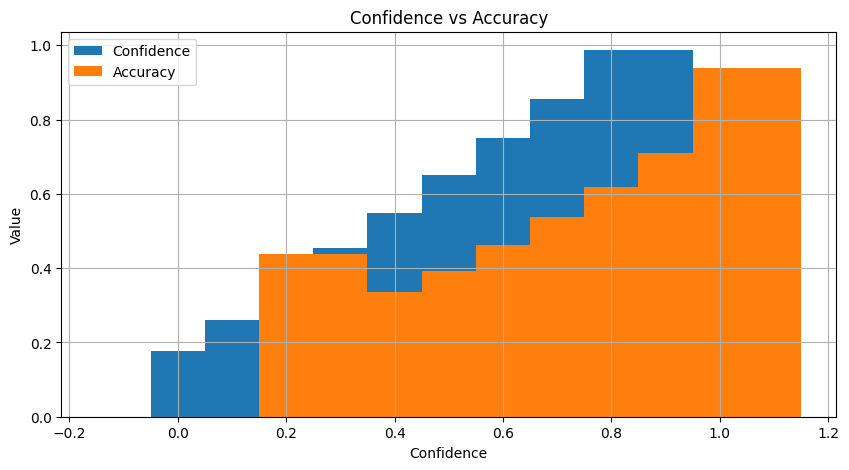

In [7]:
# TODO: Plot confidence calibration curve and calculate expected calibration error (1 point), using 
ece = np.sum(bin_frac * np.abs(bin_acc - bin_conf))  # expected calibration error
print("ECE: ", ece)

# TODO: confidence versus accuracy bar chart
plt.figure(figsize=(10, 5))
width = 0.2  # width of the bars
plt.bar(bin_centers - width/2, bin_conf, width=width, label='Confidence')
plt.bar(bin_centers + width/2, bin_acc, width=width, label='Accuracy')
plt.xlabel("Confidence")
plt.ylabel("Value")
plt.title("Confidence vs Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Calculate the (c) Accuracy metric
overall_accuracy = np.mean(all_acc)
print(overall_accuracy)